In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sensitivity Analysis

You can use the results from a Monte Carlo simulation to perform sensitivity analysis.
We will first introduce the concepts of sensitivity analysis and then show how to use the `SensitivityModel` class.

It is highly recommended that you read about the Monte Carlo simulations.

## Introduction

The goal of any simulation software is to provide accurate estimates of certain
quantities. For RocketPy, the goal is to accurately estimate rockets flight
trajectories, where accuracy stands for how close are the predicted values and the
factually observed values for the variables of interest.

To understand what makes the predictions differ from observed values we have to understand
what factors increase variability in the predictions. From all sources of variation,
there are four of major importance:

1. **Rocket Physics model**: consists of the physics models used in rocketry. It encompasses
which rocketry elements we can incorporate such as different types of motors, aerodynamic
surfaces, and other rockets components along with the mathematical equations used to describe them.
2. **Numerical approximations**: consists of how well we can solve the physics equations.
Analytic solutions are seldomly available, and therefore we must resort on numerical
approximations.
3. **Weather forecast**: consists of how well the environment is predicted. Accurate predictions 
are crucial for rocketry simulation as many components are influenced by it.
4. **Measurement uncertainty**: consists of measurement errors. Every instrument has a limited
precision, which causes us to simulate flights with parameters values that are not the true
values but should be somewhat close.

Accurate predictions require dealing carefully with each source of variation, and this is
RocketPy's goal. The first two sources of variation are naturally handled in the simulator
itself as the library is enhanced with new rocketry components and computational methods.
Weather forecasting is also described extensively in RocketPy, where we allow the forecast
to be customized, come from different reference sources and even be an ensemble from forecasts.

The goal of sensitivity analysis is to analyze the variation due to measurement uncertainty.
Sensitivity analysis quantifies the magnitude of the effect that the variability in rocket parameters 
causes in variables of interest.

To give a more clear example, assume that a rocketeer wishes to estimate the apogee as
accurately as possible.
They measure the rocket mass $M$ (kg) with precision $\epsilon_1$ (kg).
Then, he measures that the rocket has radius $R$ (m) with precision $\epsilon_2$ (m).
The uncertainty in these measures will cause variability in the apogees estimation.
Which of these uncertainties is more relevant for the variability of the apogee?
This is the kind of question we will try to answer.


### Importing the dataset from Monte Carlo simulations

Performing a sensitivity analysis requires running a Monte Carlo simulation
first. We need to:

- specify distribution used for each stochastic parameter;
- import and specify the parameter sampled for each flight simulation;
- import and specify the target variables we are interested in the analysis.


The dataset was created in the "monte_carlo_sensitivity_simulation" notebook. We considered
a rocket very similar to Calisto, the one used in the getting started notebook. We used
a tomorrows forecast for the environment and did not take weather uncertainty into
consideration when performing the analysis. For more details on how the dataset was
obtained, see the referred notebook.

Here we will analyze how some `Rocket`, `Motor`, `Parachute` and `Flight` parameters
affect the apogee. Every stochastic parameter is listed in the dictionary below. We
sampled them considering a Gaussian distribution with `mean` and `std` as specified below.

In [10]:
analysis_parameters = {
    # Rocket
    "mass": {"mean": 14.426, "std": 0.5},
    "radius": {"mean": 127 / 2000, "std": 1 / 1000},
    # Motor
    "motors_dry_mass": {"mean": 1.815, "std": 1 / 100},
    "motors_grain_density": {"mean": 1815, "std": 50},
    "motors_total_impulse": {"mean": 6500, "std": 50},
    "motors_burn_out_time": {"mean": 3.9, "std": 0.2},
    "motors_nozzle_radius": {"mean": 33 / 1000, "std": 0.5 / 1000},
    "motors_grain_separation": {"mean": 5 / 1000, "std": 1 / 1000},
    "motors_grain_initial_height": {"mean": 120 / 1000, "std": 1 / 100},
    "motors_grain_initial_inner_radius": {"mean": 15 / 1000, "std": 0.375 / 1000},
    "motors_grain_outer_radius": {"mean": 33 / 1000, "std": 0.375 / 1000},
    # Parachutes
    "parachutes_cd_s": {"mean": 10, "std": 0.1},
    "parachutes_lag": {"mean": 1.5, "std": 0.1},
    # Flight
    "heading": {"mean": 53, "std": 2},
    "inclination": {"mean": 84.7, "std": 1},
}

Next, we load the monte carlo data using the `load_monte_carlo_data` function.

In [11]:
from rocketpy.tools import load_monte_carlo_data


target_variables = ["apogee"]
parameters = list(analysis_parameters.keys())

parameters_matrix, target_variables_matrix = load_monte_carlo_data(
    input_filename="monte_carlo_analysis_outputs/sensitivity_analysis_data.inputs.txt",
    output_filename="monte_carlo_analysis_outputs/sensitivity_analysis_data.outputs.txt",
    parameters_list=parameters,
    target_variables_list=target_variables,
)

## Creating and fitting a `SensitivityModel`

We pass the parameters list and target variables list to the `SensitivityModel`
object in order to create it.

In [12]:
from rocketpy import SensitivityModel

model = SensitivityModel(parameters, target_variables)

If we know the nominal values for the parameters and target variables in the
simulation, we can pass them using the methods `set_parameters_nominal` and
`set_target_variables_nominal`. If we do not pass it to the model, the fit method
estimates them from data. In this example, we will pass the nominal values only for the
parameters and let the method estimate the nominals for the target variables.

In [13]:
parameters_nominal_mean = [
    analysis_parameters[parameter_name]["mean"]
    for parameter_name in analysis_parameters.keys()
]
parameters_nominal_sd = [
    analysis_parameters[parameter_name]["std"]
    for parameter_name in analysis_parameters.keys()
]
model.set_parameters_nominal(parameters_nominal_mean, parameters_nominal_sd)

Finally, we fit the model by passing the parameters and target
variables matrices loaded previously.

In [14]:
model.fit(parameters_matrix, target_variables_matrix)

## Results

The results can be accessed through the `prints` and `plots` attributes, just like any other rocketpy object.

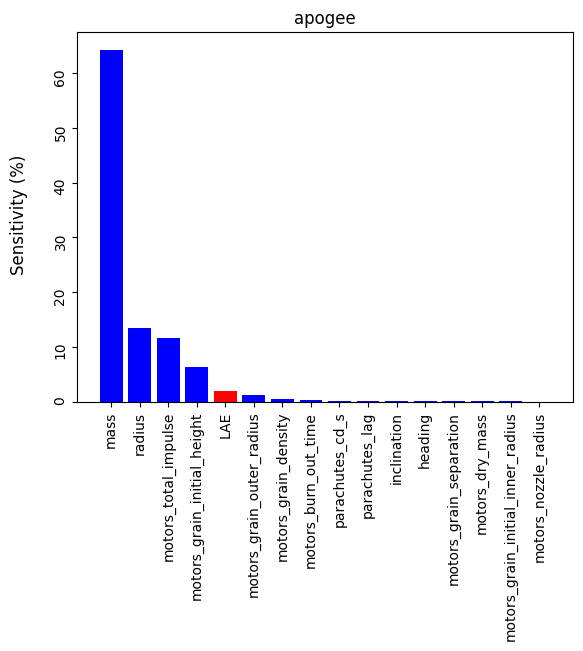

In [15]:
model.plots.bar_plot()

In [16]:
model.prints.all()

+--------------------------------------------------------------------------------------------------------------------+
|                                                   Summary apogee                                                   |
+-----------------------------------+-----------------+--------------+------------+------------------------+---------+
|             Parameter             | Sensitivity (%) | Nominal mean | Nominal sd | Regression Coefficient | p-value |
+-----------------------------------+-----------------+--------------+------------+------------------------+---------+
|                mass               |     64.3755     |    14.426    |    0.5     |       -179.8674        |  0.8928 |
|               radius              |     13.4991     |    0.0635    |   0.001    |      -41182.6938       |   0.0   |
|        motors_total_impulse       |     11.7046     |     6500     |     50     |         0.767          |   0.0   |
|    motors_grain_initial_height    |      6.358

## Final considerations

Sensitivity analysis is a useful tool to investigate the statistical relevance of parameters in the variables of interest.
As any statistics tool, we must be careful so that sensitivity analysis provides valid results.

We should always:

- check if all variables relevant to understand the variability of a certain target variable are passed.
- check if the linear approximation error (LAE) is not too large. This could happen because important variables were omitted, or because the weather forecast uncertainty is much more important than the specified measurements uncertainty. If both of these were considered and the LAE is still large, then the linear approximation might be strongly violated and the results.

